# Installation and Setup

In [3]:
# Pyspark
!pip install pyspark
!PYSPARK_HADOOP_VERSION=3 pip install pyspark
!PYSPARK_HADOOP_VERSION=3 pip install pyspark -v
!pip install pyspark-connect

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 MB 2.4 MB/s  0:02:330:00:0100:05
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-4.0.1-py2.py3-none-any.whl size=434813860 sha256=caf5f69b578d735d9b9eacf0b3c561f7b38da46988692f3f8f698deb8ce6afef
  Stored in directory: /home/vscode/.cache/pip/wheels/31/9f/68/f89fb34ccd886909be7d0e390eaaf97f21efdf540c0ee8dbcd
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyspark]m1/2 [pyspark]
Defaulting to user installation because normal site-packages is not writeable
Using pip 25.2 from /home/vscode/.local/lib/python3.12/site-packages/pip (python 3.12)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  

In [ ]:
!pip install polars
!pip install pandas
!pip install matplotlib
!pip install mplfinance
!pip install seaborn
!pip install numpy


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


# Benchmark Pandas v/s Polars v/s Pyspark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("DataFrameLoader").getOrCreate()
# try:
#     spark.stop()
# except:
#     pass

JAVA_HOME is not set


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [ ]:
import pandas as pd
import polars as pl
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, year, mean as Fmean
import matplotlib.pyplot as plt
import time

class DataFrameLoader:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        try:
            self.spark = SparkSession.builder.appName("DataFrameLoader").getOrCreate()
        except:
            self.spark = None

    def load(self, library='pandas'):
        library = library.lower()

        if library == 'pandas':
            df = pd.read_csv(self.csv_path)
            # Keep Timestamp as epoch seconds
            return df

        elif library == 'polars':
            df = pl.read_csv(self.csv_path)
            # Keep Timestamp as Int64 (epoch seconds)
            if "Timestamp" in df.columns and df["Timestamp"].dtype not in [pl.Int64, pl.Float64]:
                df = df.with_columns(pl.col("Timestamp").cast(pl.Int64))
            return df

        elif library == 'pyspark':
            if self.spark is None:
                raise ValueError("Spark session not initialized")
            df = self.spark.read.csv(self.csv_path, header=True, inferSchema=True)
            # Keep Timestamp as epoch seconds (LongType)
            if "Timestamp" in df.columns:
                df = df.withColumn("Timestamp", col("Timestamp").cast("long"))
            return df

        else:
            raise ValueError("Unsupported library. Choose 'pandas', 'polars', or 'pyspark'.")

    def benchmark(self):
        libraries = ['pandas', 'polars', 'pyspark']
        timings = {lib: {} for lib in libraries}

        for lib in libraries:
            start = time.time()
            df = self.load(lib)
            timings[lib]['read'] = time.time() - start

            start = time.time()
            if lib == 'pyspark':
                df.show(5, truncate=False)
            else:
                df.head()
            timings[lib]['head'] = time.time() - start

            start = time.time()
            if lib == 'pandas':
                _ = df[df['Close'] > 50000]
            elif lib == 'polars':
                _ = df.filter(pl.col("Close") > 50000)
            elif lib == 'pyspark':
                _ = df.filter(df["Close"] > 50000).count()
            timings[lib]['filter'] = time.time() - start

            start = time.time()
            # ---------- GroupBy Year ----------
            if 'Timestamp' in df.columns:
                if lib == 'pandas':
                    # convert epoch to year on the fly
                    df['Year'] = pd.to_datetime(df['Timestamp'], unit='s').dt.year
                    _ = df.groupby('Year')['Close'].mean()
                elif lib == 'polars':
                    df = df.with_columns(
                        ((pl.col("Timestamp") / 31556952 + 1970).cast(pl.Int64)).alias("Year")
                    )  # rough approximation: seconds in a year
                    _ = df.group_by("Year").agg(pl.mean("Close"))
                elif lib == 'pyspark':
                    df = df.withColumn("Year", year(from_unixtime(col("Timestamp"))))
                    _ = df.groupBy("Year").agg(Fmean("Close"))
            timings[lib]['groupby_mean'] = time.time() - start

        # ---------- Plot ----------
        ops = ['read', 'head', 'filter', 'groupby_mean']
        x = range(len(libraries))
        plt.figure(figsize=(12,6))

        for idx, op in enumerate(ops):
            times = [timings[lib][op] for lib in libraries]
            plt.bar([i + idx*0.2 for i in x], times, width=0.2, label=op)

        plt.xticks([i + 0.3 for i in x], libraries)
        plt.ylabel('Time (seconds)')
        plt.title('CSV Benchmark: Pandas vs Polars vs PySpark (Epoch Timestamp)')
        plt.legend()
        plt.show()

        return timings

# LOAD AND BENCHMARK
csv_file_path = "btcusd_1-min_data.csv"
loader = DataFrameLoader(csv_file_path)


#### It can be seen that for a dataset size of approx 350MB, the overhead of pyspark is not justified and leads to worse comparision compared to Polars and even Pandas

+----------+----+----+----+-----+------+
|Timestamp |Open|High|Low |Close|Volume|
+----------+----+----+----+-----+------+
|1325412060|4.58|4.58|4.58|4.58 |0.0   |
|1325412120|4.58|4.58|4.58|4.58 |0.0   |
|1325412180|4.58|4.58|4.58|4.58 |0.0   |
|1325412240|4.58|4.58|4.58|4.58 |0.0   |
|1325412300|4.58|4.58|4.58|4.58 |0.0   |
+----------+----+----+----+-----+------+
only showing top 5 rows


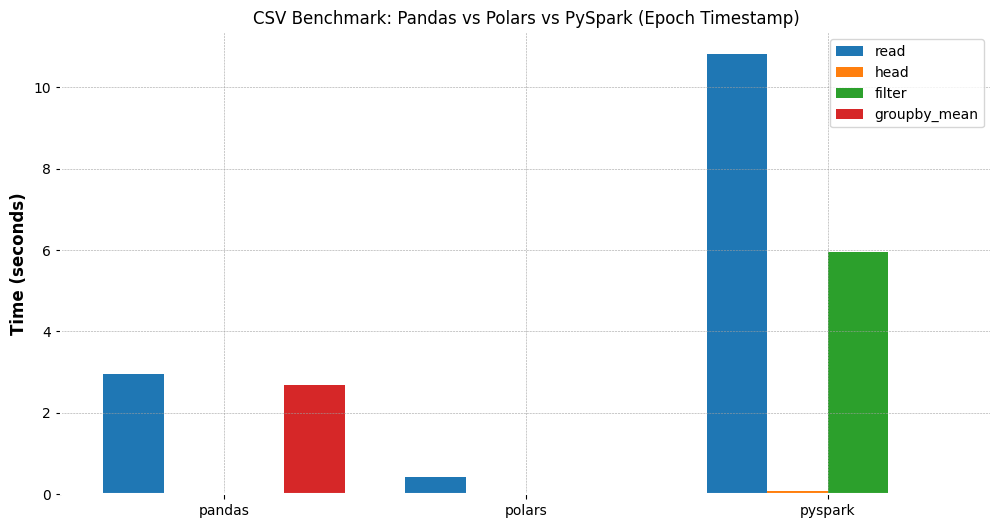

Benchmark results (in seconds):
pandas {'read': 2.9465601444244385, 'head': 0.00018596649169921875, 'filter': 0.03913307189941406, 'groupby_mean': 2.677454948425293}
polars {'read': 0.41265392303466797, 'head': 6.389617919921875e-05, 'filter': 0.007007122039794922, 'groupby_mean': 0.03651690483093262}
pyspark {'read': 10.807034015655518, 'head': 0.07787418365478516, 'filter': 5.950787782669067, 'groupby_mean': 0.006757259368896484}


In [ ]:
# BENCHMARK
benchmark_results = loader.benchmark()
print("Benchmark results (in seconds):")
for lib, results in benchmark_results.items():
    print(lib, results)

In [2]:
!pip install polars
!pip install matplotlib
!pip install numpy
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 5.7 MB/s  0:00:06m0:00:0100:01m
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 11.4 MB/s  0:00:00m0:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 12.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 8.5 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 8.8 MB/s  0:00:00 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 7.8 MB/s  0:00:01m0:00:010:01m
   ━━━━━━━━━━━━

# Exploratory Data Analysis

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------
# 1. Load dataset
# ------------------------
df = loader.load('polars')

# Detect dtype
print(df["Timestamp"][-1])

df = df.with_columns([
    (pl.col("Timestamp") * 1000).cast(pl.Datetime("ms")).alias("Timestamp_dt")
])

# ------------------------
# 2. Basic overview
# ------------------------
print("Data shape:", df.shape)
print(df.describe())


In [ ]:
# ------------------------
# 3. Price Trend Over Time
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(df["Timestamp_dt"].to_numpy(), df["Close"].to_numpy(), label="Close Price", color="blue")
plt.plot(df["Timestamp_dt"].to_numpy(), df["Open"].to_numpy(), label="Open Price", color="orange", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Trend")
plt.legend()
plt.show()

# ------------------------
# Filter for last one hour to observe trend better
# ------------------------
two_years_seconds = 3600  # 1 hour in seconds
window_time = df["Timestamp"].max()

df_recent = df.filter(pl.col("Timestamp") > (window_time - two_years_seconds))

plt.figure(figsize=(15,5))
plt.plot(df_recent["Timestamp_dt"].to_numpy(), df_recent["Close"].to_numpy(), label="Close Price", color="blue")
plt.plot(df_recent["Timestamp_dt"].to_numpy(), df_recent["Open"].to_numpy(), label="Open Price", color="orange", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Trend (Last One Hour)")
plt.legend()
plt.show()

In [ ]:
# ------------------------
# 4. Volume Trend Over Time
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(df["Timestamp_dt"].to_numpy(), df["Volume"].to_numpy(), color="green", alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Volume (BTC)")
plt.title("Bitcoin Trading Volume (Line Plot)")
plt.show()

In [ ]:

# ------------------------
# 5. Returns & Distribution
# ------------------------
df = df.with_columns([
    (pl.col("Close").pct_change()).alias("returns")
])
returns = df["returns"].to_numpy()

plt.figure(figsize=(10,5))
sns.histplot(returns, bins=100, kde=True, color="purple")
plt.title("Distribution of Returns")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# ------------------------
# 6. Rolling Volatility
# ------------------------
df = df.with_columns([
    pl.col("returns").rolling_std(60).alias("volatility_60s")  # 60-second rolling window
])
plt.figure(figsize=(15,5))
plt.plot(df["Timestamp_dt"].to_numpy(), df["volatility_60s"].to_numpy(), color="red")
plt.title("Rolling 60s Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

In [ ]:
# ------------------------
# 7. Correlation Heatmap
# ------------------------
df_pandas = df.to_pandas()
numeric_cols = ["Open","High","Low","Close","Volume","returns"]
corr = df_pandas[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# ------------------------
# 8. Candlestick Preview
# ------------------------
import mplfinance as mpf

rows = 50
# Convert last rows to Pandas
df_candle_pd = df.sort("Timestamp_dt", descending=True).head(rows).to_pandas()

# Set index for mplfinance
df_candle_pd.set_index("Timestamp_dt", inplace=True)

# Plot candlestick
mpf.plot(
    df_candle_pd,
    type="candle",
    volume=True,
    style="charles",
    title=f"Last {rows} Candles"
)

# Feature Engineering

df = loader.load('polars')

In [ ]:
df = df.with_columns([
    (pl.col("Close") / pl.col("Close").shift(1) - 1).alias("return"),
    (pl.col("High") - pl.col("Low")).alias("high_low_spread"),
    (pl.col("Close") - pl.col("Open")).alias("open_close_diff"),
    (pl.col("Close") - pl.col("Open")).abs().alias("candle_body"),
    (pl.col("High") - pl.concat_list([pl.col("Close"), pl.col("Open")]).max().over("Close")).alias("candle_upper_shadow"),
    (pl.concat_list([pl.col("Close"), pl.col("Open")]).min().over("Close") - pl.col("Low")).alias("candle_lower_shadow")
])
df.tail(10).to_pandas()

In [ ]:

# Lag features
lags = [1, 2, 3, 5, 10]
for lag in lags:
    df = df.with_columns([
        pl.col("Close").shift(lag).alias(f"Close_lag_{lag}"),
        pl.col("Volume").shift(lag).alias(f"Volume_lag_{lag}")
    ])
df.tail(10).to_pandas()

In [ ]:

# Rolling features (shifted to prevent leakage)
df = df.with_columns([
    pl.col("Close").rolling_mean(5).shift(1).alias("SMA_5"),
    pl.col("Close").rolling_mean(10).shift(1).alias("SMA_10"),
    pl.col("Close").ewm_mean(alpha=2/(5+1)).shift(1).alias("EMA_5"),
    pl.col("Close").ewm_mean(alpha=2/(10+1)).shift(1).alias("EMA_10"),
    (pl.col("Close").rolling_std(5).shift(1)).alias("volatility_5"),
    (pl.col("Close").rolling_std(10).shift(1)).alias("volatility_10"),
    (pl.col("High") - pl.col("Low")).alias("tr"),
    (pl.col("High") - pl.col("Low")).rolling_mean(5).shift(1).alias("ATR_5"),
    (pl.col("Volume").pct_change().shift(1)).alias("volume_change"),
    (pl.col("Volume").rolling_mean(5).shift(1)).alias("vol_ma_5"),
    (pl.col("Volume").rolling_mean(10).shift(1)).alias("vol_ma_10"),
])
df.tail(10).to_pandas()

In [ ]:
# RSI 14 

# Calculate delta
df = df.with_columns([
    (pl.col("Close").diff().alias("delta"))
])

# Compute gain and loss
df = df.with_columns([
    pl.when(pl.col("delta") > 0).then(pl.col("delta")).otherwise(0).alias("gain"),
    pl.when(pl.col("delta") < 0).then(-pl.col("delta")).otherwise(0).alias("loss")
])

# Compute rolling average of gain/loss (14 periods), shifted by 1 to prevent leakage
df = df.with_columns([
    pl.col("gain").rolling_mean(window_size=14, min_periods=1).shift(1).alias("avg_gain"),
    pl.col("loss").rolling_mean(window_size=14, min_periods=1).shift(1).alias("avg_loss")
])

# Compute RSI
df = df.with_columns([
    (100 - 100 / (1 + (pl.col("avg_gain") / pl.col("avg_loss")))).alias("RSI_14")
])
df.tail(10).to_pandas()

In [ ]:

# MACD
ema_12 = df["Close"].ewm_mean(alpha=2/(12+1)).shift(1)
ema_26 = df["Close"].ewm_mean(alpha=2/(26+1)).shift(1)
macd = ema_12 - ema_26
macd_signal = macd.ewm_mean(alpha=2/(9+1)).shift(1)
df = df.with_columns([
    macd.alias("MACD"),
    macd_signal.alias("MACD_signal")
])
df.tail(10).to_pandas()

In [ ]:
# Bollinger Bands
bb_mid = df["Close"].rolling_mean(20).shift(1)
bb_std = df["Close"].rolling_std(20).shift(1)
df = df.with_columns([
    bb_mid.alias("BB_mid"),
    bb_std.alias("BB_std"),
    (bb_mid + 2*bb_std).alias("BB_upper"),
    (bb_mid - 2*bb_std).alias("BB_lower")
])
df.tail(10).to_pandas()


# Train / Test Split

In [ ]:
df = df.with_columns([ df["Close"].shift(-1).alias("target") ]) 

original_rows = df.height

# Filter nulls
essential_features = ["Close", "Open", "High", "Low", "Volume"]
mask = pl.col(essential_features[0]).is_not_null()
for col in essential_features[1:]:
    mask = mask & pl.col(col).is_not_null()
df_filtered = df.filter(mask & pl.col("target").is_not_null())

filtered_rows = df_filtered.height
print("Rows dropped:", original_rows - filtered_rows)


In [ ]:
feature_cols = [col for col in df.columns if col not in ["Timestamp", "target"]] 
X = df.select(feature_cols).to_numpy() 
y = df["target"].to_numpy() 
train_size = int(len(df) * 0.8) 
X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Scaling

In [ ]:
import numpy as np

# Ensure numeric type (float64)
X_train = X_train.astype(np.float64, copy=False)
X_test  = X_test.astype(np.float64, copy=False)

# Clean inplace
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=0.0, neginf=0.0)

# Verify
print("NaNs in X_train:", np.isnan(X_train).sum())
print("Infs in X_train:", np.isinf(X_train).sum())
print("dtype:", X_train.dtype)


In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

# Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled) 
print("Original features:", X_train.shape[1]) 
print("PCA features:", X_train_pca.shape[1])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Explained variance ratio
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(14,5))

# 1. Scree plot
plt.subplot(1,2,1)
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title("Explained Variance Ratio per Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")

# 2. Cumulative explained variance
plt.subplot(1,2,2)
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', color="orange")
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()

plt.tight_layout()
plt.show()


# 7. Train Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Take a subset of the training data
# Pick Latest 50000 rows for training -> Approx Last 1/3 month data 

subset_size = 500000
X_train_subset = X_train_pca[-subset_size:]
y_train_subset = y_train[-subset_size:]

rf_model = RandomForestRegressor(
    n_estimators=100,    # fewer trees for a quick test
    max_depth=10,         # shallower trees, faster
    random_state=42,
    n_jobs=-1,           # use all CPU cores
    verbose=1            # prints minimal progress info
)

# Train on the small subset
rf_model.fit(X_train_subset, y_train_subset)


# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

X_test_pca = np.nan_to_num(X_test_pca, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

subset = 50000
X_test_pca_subset = X_test_pca[-subset:]
y_test_subset = y_test[-subset:]
# ------------------------
# 1. Predict on test set
# ------------------------
y_pred_subset = rf_model.predict(X_test_pca_subset)

# ------------------------
# 2. Evaluate
# ------------------------
rmse = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset))
r2 = r2_score(y_test_subset, y_pred_subset)
print("RMSE:", rmse)
print("R²:", r2)

# ------------------------
# 3. Feature importance
# ------------------------
plt.figure(figsize=(12,6))
plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.xlabel("PCA Component")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances (PCA components)")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Residuals
residuals = y_test_subset - y_pred_subset

plt.figure(figsize=(12,5))

# 1. Residual plot
plt.subplot(1,2,1)
plt.scatter(y_pred_subset, residuals, alpha=0.5, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

# 2. Actual vs Predicted
plt.subplot(1,2,2)
plt.scatter(y_test_subset, y_pred_subset, alpha=0.5, color='orange')
plt.plot([y_test_subset.min(), y_test_subset.max()],
         [y_test_subset.min(), y_test_subset.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.tight_layout()
plt.show()


# Assume X_test, y_test correspond to the last N rows of df
df = df.with_columns([ (pl.col("Timestamp") * 1000).cast(pl.Datetime("ms")).alias("Timestamp_dt") ])
df_test_subset = df.tail(len(y_pred_subset)).select(["Timestamp_dt"]).to_pandas()

plt.figure(figsize=(15,5))
plt.plot(df_test_subset["Timestamp_dt"], residuals, label="Residuals", color="teal")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residuals over Time")
plt.legend()
plt.show()

